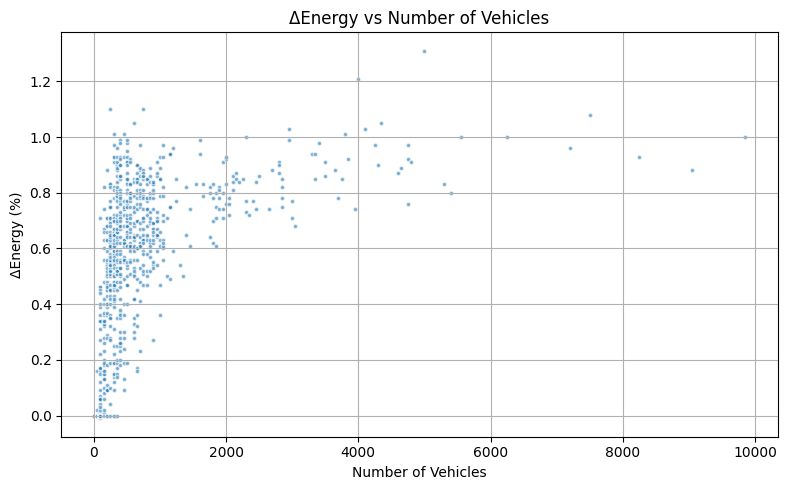

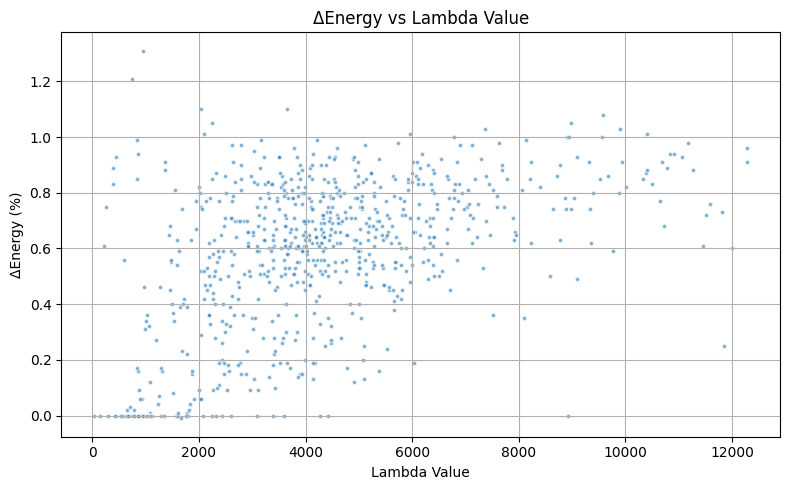

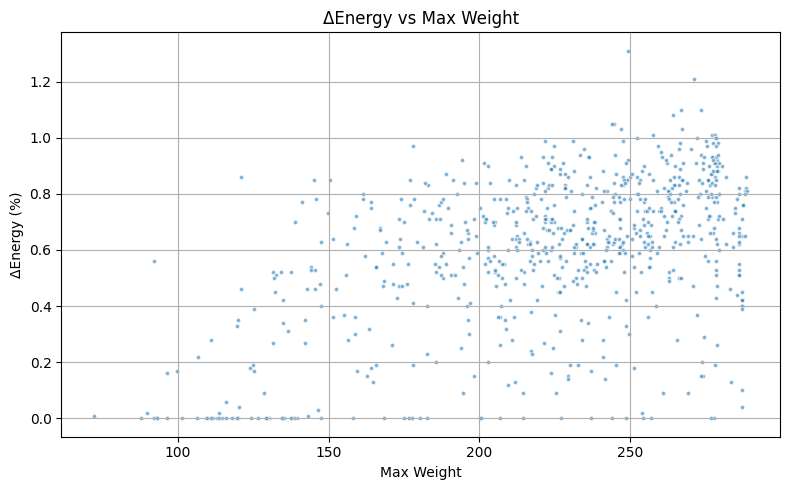

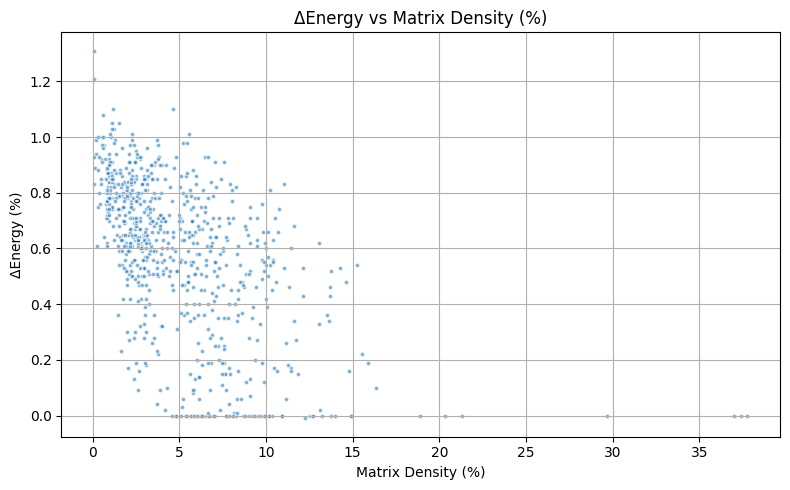

In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sqlalchemy import text
from sqlalchemy.orm import sessionmaker
from models import *  # Assumes engine is imported from here

def create_db_session():
    """Create a new database session."""
    Session = sessionmaker(bind=engine, autocommit=False)
    return Session()

# === Configuration ===
session = create_db_session()
sql_name = "qubo_energy_data.sql"

# Get base directory (e.g., .../project_root/src)
base_dir = os.path.dirname(os.getcwd())


# Point to src/sql/qubo_energy_data.sql
sql_file = os.path.join(base_dir, 'sql', sql_name)

# === Load SQL from file and execute ===
with open(sql_file, "r") as f:
    sql_query = f.read()

df = pd.read_sql(text(sql_query), session.bind)

# === Clean and preprocess ===
df["delta_energy"] = df["delta_energy"].str.replace('%', '', regex=False).astype(float)
df["matrix_density"] = df["matrix_density"].astype(str).str.replace('%', '', regex=False).astype(float)

# === Scatter plot helper ===
def plot_scatter(x, y="delta_energy", xlabel=None):
    plt.figure(figsize=(8, 5))
    plt.scatter(df[x], df[y], alpha=0.6, edgecolors='w', s=10)
    plt.xlabel(xlabel or x)
    plt.ylabel("ΔEnergy (%)")
    plt.title(f"ΔEnergy vs {xlabel or x}")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f"scatter_{x}.png")
    plt.show()

# === Generate scatter plots ===
plot_scatter("rounded_vehicles", xlabel="Number of Vehicles")
plot_scatter("lambda_value", xlabel="Lambda Value")
plot_scatter("max_weight", xlabel="Max Weight")
plot_scatter("matrix_density", xlabel="Matrix Density (%)")


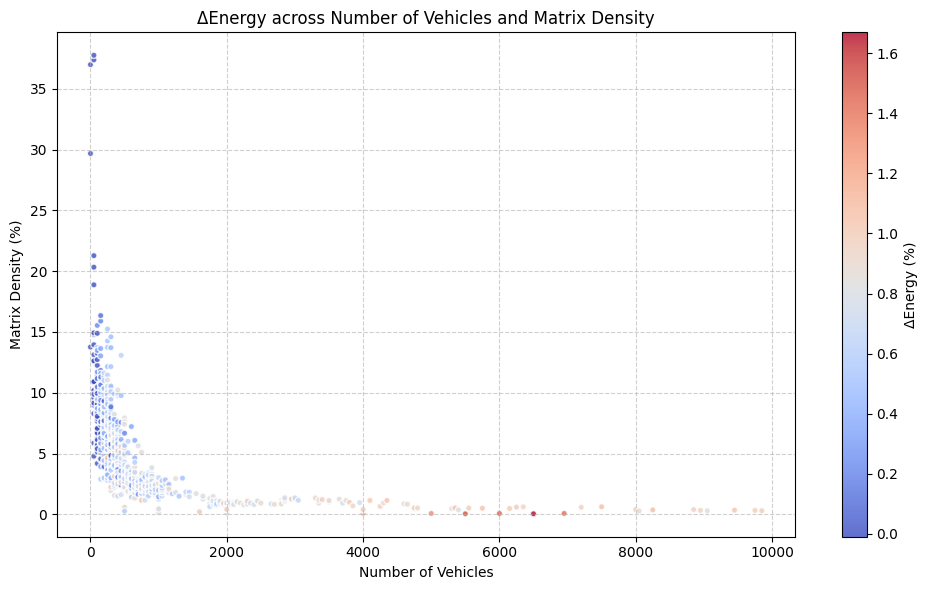

In [26]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sqlalchemy import text
from sqlalchemy.orm import sessionmaker
from models import *  # Assumes engine is imported from here

def create_db_session():
    """Create a new database session."""
    Session = sessionmaker(bind=engine, autocommit=False)
    return Session()

# === Configuration ===
session = create_db_session()
sql_name = "qubo_energy_data.sql"

# Get base directory (e.g., .../project_root/src)
base_dir = os.path.dirname(os.getcwd())

# Point to src/sql/qubo_energy_data.sql
sql_file = os.path.join(base_dir, 'sql', sql_name)

# === Load SQL from file and execute ===
with open(sql_file, "r") as f:
    sql_query = f.read()

df = pd.read_sql(text(sql_query), session.bind)

# === Clean and preprocess ===
df["delta_energy"] = df["delta_energy"].str.replace('%', '', regex=False).astype(float)
df["matrix_density"] = df["matrix_density"].astype(str).str.replace('%', '', regex=False).astype(float)

# === Scatter plot: Vehicles vs Density, colored by ΔEnergy ===
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["rounded_vehicles"],
    df["matrix_density"],
    c=df["delta_energy"],         # color by ΔEnergy
    cmap="coolwarm",              # blue=low, red=high (adjustable)
    alpha=0.8,
    edgecolors="w",
    s=20
)

plt.xlabel("Number of Vehicles")
plt.ylabel("Matrix Density (%)")
plt.title("ΔEnergy across Number of Vehicles and Matrix Density")
cbar = plt.colorbar(scatter)
cbar.set_label("ΔEnergy (%)")

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


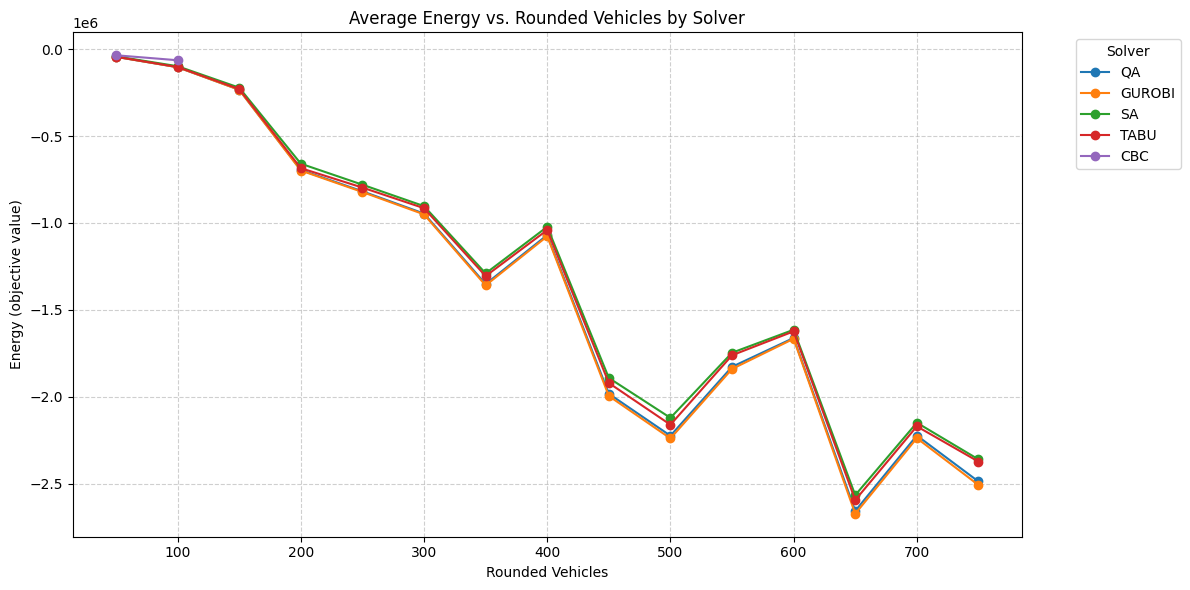

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text
from sqlalchemy.orm import sessionmaker
from models import *  # expects `engine` to be defined here

def create_db_session():
    """Create a new database session."""
    Session = sessionmaker(bind=engine, autocommit=False)
    return Session()

# === Configuration ===
session = create_db_session()
sql_name = "energy_compare.sql"  # save your provided SQL into src/sql/solver_energy_by_vehicles.sql

# Get base directory (e.g., .../project_root/src)
base_dir = os.path.dirname(os.getcwd())
sql_file = os.path.join(base_dir, "sql", sql_name)

# === Load SQL from file and execute ===
with open(sql_file, "r") as f:
    sql_query = f.read()

df = pd.read_sql(text(sql_query), session.bind)

# === Clean & rename columns ===
# Some DBs return 'count(*)' as the exact column name. Normalize it.
rename_map = {}
for col in df.columns:
    if col.strip().lower() in {"count(*)", "count"}:
        rename_map[col] = "n_instances"
if rename_map:
    df = df.rename(columns=rename_map)

# Ensure expected columns exist
expected = [
    "rounded_vehicles",
    "qa_energy",
    "gurobi_energy",
    "sa_energy",
    "tabu_energy",
    "cbc_energy",
]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in query result: {missing}")

# Sort for consistent plotting
df = df.sort_values("rounded_vehicles")

# === Plot energies vs rounded_vehicles ===
plt.figure(figsize=(12, 6))
for col in ["qa_energy", "gurobi_energy", "sa_energy", "tabu_energy", "cbc_energy"]:
    plt.plot(
        df["rounded_vehicles"],
        df[col],
        marker="o",
        label=col.replace("_energy", "").upper()
    )

plt.xlabel("Rounded Vehicles")
plt.ylabel("Energy (objective value)")
plt.title("Average Energy vs. Rounded Vehicles by Solver")
plt.grid(True, linestyle="--", alpha=0.6)

# Legend outside the plot
plt.legend(title="Solver", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()
